# Logistic regression classification 
Logistic regression classification is a popular and widely used machine learning algorithm for solving classification problems. It is a statistical method that is used to analyze and model the relationships between one or more independent variables and a dependent binary variable. In other words, logistic regression is used to predict the probability of an event occurring based on the values of input features.

In this Jupyter notebook, we will explore how to use logistic regression for classification problems using PySpark. Specifically, we will use the Breast Cancer Wisconsin dataset, which contains information about various features of breast tumors, to build a logistic regression model that can predict whether a tumor is malignant or benign based on its characteristics. We will cover the following topics:

Loading and preparing the data
Training a logistic regression model using PySpark's MLlib library
Evaluating the model's performance using various metrics
Tuning the model's hyperparameters to improve its performance
By the end of this notebook, you should have a good understanding of how logistic regression works and how to apply it to real-world classification problems using PySpark.

## Introduction

### Description of the dataset iris

The iris dataset is a classic and widely used dataset in machine learning and statistics. It contains measurements of the sepal length, sepal width, petal length, and petal width for 150 iris flowers, with 50 samples from each of three different species (setosa, versicolor, and virginica). The dataset was first introduced in a 1936 paper by the British statistician and biologist Ronald Fisher, and has since become a popular example for exploring and practicing machine learning algorithms.

The iris dataset is often used for classification tasks, as the goal is to predict the species of an iris flower based on its measurements. It is also a good dataset for exploring and visualizing data, as the different species have distinct characteristics that can be easily visualized with scatter plots or other techniques.

Overall, the iris dataset is a useful and interesting dataset for anyone working in the fields of machine learning, statistics, or data science.

### Importing necessary libraries and download dataset 

In [22]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import RFormula
from pyspark.ml.feature import StandardScaler, MinMaxScaler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import TrainValidationSplit

#### Downloading the Breast Cancer Wisconsin dataset
Next, we will download the Wine dataset using the curl command. The dataset is available in a CSV format.

Each column represents the following information:

- id: An integer column representing the unique identifier for each sample in the dataset.
- clump_thickness: An integer column representing the clump thickness of cells in the sample, on a scale of 1-10.
- uniformity_of_cell_size: An integer column representing the uniformity of cell size in the sample, on a scale of 1-10.
- uniformity_of_cell_shape: An integer column representing the uniformity of cell shape in the sample, on a scale of 1-10.
- marginal_adhesion: An integer column representing the degree of adhesion of cells in the sample to surrounding tissue, on a scale of 1-10.
- single_epithelial_cell_size: An integer column representing the size of the epithelial cells in the sample, on a scale of 1-10.
- bare_nuclei: A string column representing the number of bare nuclei present in the sample, on a scale of 1-10. Note that this column contains missing or unknown values, represented by the string '?'.
- bland_chromatin: An integer column representing the chromatin pattern in the sample, on a scale of 1-10.
- normal_nucleoli: An integer column representing the number of normal nucleoli present in the sample, on a scale of 1-10.
- mitoses: An integer column representing the number of mitoses observed in the sample, on a scale of 1-10.
- class: An integer column representing the class label for each sample, where 2 indicates a benign tumor and 4 indicates a malignant tumor.

In [ ]:
! curl -o breast_cancer_wisconsin.csv https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data

In [3]:
from pyspark.sql.types import *

schema = StructType([
    StructField("id", IntegerType()),
    StructField("clump_thickness", IntegerType()),
    StructField("uniformity_of_cell_size", IntegerType()),
    StructField("uniformity_of_cell_shape", IntegerType()),
    StructField("marginal_adhesion", IntegerType()),
    StructField("single_epithelial_cell_size", IntegerType()),
    StructField("bare_nuclei", StringType()),
    StructField("bland_chromatin", IntegerType()),
    StructField("normal_nucleoli", IntegerType()),
    StructField("mitoses", IntegerType()),
    StructField("class", IntegerType())
])

# init SparkSession
spark = SparkSession.builder.appName('LRClassifier').getOrCreate()
# read the csv using pyspark
cancer = spark.read.csv('./breast_cancer_wisconsin.csv', schema=schema, header=False)

# print few lines of the dataframe
cancer.show(5)

+-------+---------------+-----------------------+------------------------+-----------------+---------------------------+-----------+---------------+---------------+-------+-----+
|     id|clump_thickness|uniformity_of_cell_size|uniformity_of_cell_shape|marginal_adhesion|single_epithelial_cell_size|bare_nuclei|bland_chromatin|normal_nucleoli|mitoses|class|
+-------+---------------+-----------------------+------------------------+-----------------+---------------------------+-----------+---------------+---------------+-------+-----+
|1000025|              5|                      1|                       1|                1|                          2|          1|              3|              1|      1|    2|
|1002945|              5|                      4|                       4|                5|                          7|         10|              3|              2|      1|    2|
|1015425|              3|                      1|                       1|                1|             

## Exploratory Data Analysis

### Summary statistics of the dataset

In this section, we will explore the iris datasets giving some statistic description like mean, std, etc.

In [4]:
from pyspark.sql.functions import round
temp = cancer.drop('class', 'id')
temp.describe().select(['summary'] + [round(c, 2).alias(c) for c in temp.columns]).show()

+-------+---------------+-----------------------+------------------------+-----------------+---------------------------+-----------+---------------+---------------+-------+
|summary|clump_thickness|uniformity_of_cell_size|uniformity_of_cell_shape|marginal_adhesion|single_epithelial_cell_size|bare_nuclei|bland_chromatin|normal_nucleoli|mitoses|
+-------+---------------+-----------------------+------------------------+-----------------+---------------------------+-----------+---------------+---------------+-------+
|  count|          699.0|                  699.0|                   699.0|            699.0|                      699.0|      699.0|          699.0|          699.0|  699.0|
|   mean|           4.42|                   3.13|                    3.21|             2.81|                       3.22|       3.54|           3.44|           2.87|   1.59|
| stddev|           2.82|                   3.05|                    2.97|             2.86|                       2.21|       3.64|   

In [5]:
from pyspark.sql.functions import count, col, when

cancer_trated = cancer.withColumn('bare_nuclei_', when(col('bare_nuclei') == '?', 0).otherwise(col('bare_nuclei'))).drop('bare_nuclei')
cancer_trated.show(5)

+-------+---------------+-----------------------+------------------------+-----------------+---------------------------+---------------+---------------+-------+-----+------------+
|     id|clump_thickness|uniformity_of_cell_size|uniformity_of_cell_shape|marginal_adhesion|single_epithelial_cell_size|bland_chromatin|normal_nucleoli|mitoses|class|bare_nuclei_|
+-------+---------------+-----------------------+------------------------+-----------------+---------------------------+---------------+---------------+-------+-----+------------+
|1000025|              5|                      1|                       1|                1|                          2|              3|              1|      1|    2|           1|
|1002945|              5|                      4|                       4|                5|                          7|              3|              2|      1|    2|          10|
|1015425|              3|                      1|                       1|                1|        

In [6]:
cancer_trated.select('class').distinct().show()

+-----+
|class|
+-----+
|    4|
|    2|
+-----+



In [7]:
cancer_trated = cancer_trated.withColumn('target', when(col('class') == 2, 0).otherwise(1)).drop('class')
cancer_trated.show(5)  

+-------+---------------+-----------------------+------------------------+-----------------+---------------------------+---------------+---------------+-------+------------+------+
|     id|clump_thickness|uniformity_of_cell_size|uniformity_of_cell_shape|marginal_adhesion|single_epithelial_cell_size|bland_chromatin|normal_nucleoli|mitoses|bare_nuclei_|target|
+-------+---------------+-----------------------+------------------------+-----------------+---------------------------+---------------+---------------+-------+------------+------+
|1000025|              5|                      1|                       1|                1|                          2|              3|              1|      1|           1|     0|
|1002945|              5|                      4|                       4|                5|                          7|              3|              2|      1|          10|     0|
|1015425|              3|                      1|                       1|                1|   

### Preprocessing the data (e.g., scaling, normalization, encoding)

Here we will use the RFormula to separate and treat the dataframe and the MinMaxScaller

In [8]:
train, test = cancer_trated.randomSplit([0.8, 0.2])

In [9]:
formula = RFormula(formula='target ~ . - id', featuresCol='features', labelCol='label', handleInvalid = "skip")
# only to see if everything is ok
formula.fit(train).transform(train).select('features', 'label').show(5)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|(18,[0,1,2,3,4,5,...|  1.0|
|(18,[0,1,2,3,4,5,...|  1.0|
|(18,[0,1,2,3,4,5,...|  1.0|
|(18,[0,1,2,3,4,5,...|  0.0|
|(18,[0,1,2,3,4,5,...|  1.0|
+--------------------+-----+
only showing top 5 rows



In [10]:
temp = formula.fit(train).transform(train)
scaler = MinMaxScaler(inputCol='features', outputCol='scaledFeatures', )
# only to see if everything is ok
scaler.fit(temp).transform(temp).select('features', 'scaledFeatures').show(5)

+--------------------+--------------------+
|            features|      scaledFeatures|
+--------------------+--------------------+
|(18,[0,1,2,3,4,5,...|(18,[0,2,3,4,5,6,...|
|(18,[0,1,2,3,4,5,...|(18,[0,1,2,3,4,5,...|
|(18,[0,1,2,3,4,5,...|(18,[0,1,2,3,4,5,...|
|(18,[0,1,2,3,4,5,...|(18,[4,5,10],[0.1...|
|(18,[0,1,2,3,4,5,...|(18,[0,1,2,3,4,5,...|
+--------------------+--------------------+
only showing top 5 rows



## Model Training
 Here we will build the model and create the pipeline that will be trained
 
### Building a Logistic Regression Classifier

Building a LR model with standard params

In [11]:
# We can also use the multinomial family for binary classification
mlr = LogisticRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8, family="multinomial")

In [13]:
pipeline = Pipeline(stages=[formula, scaler, mlr])

### Training the model on training set

In [14]:
model = pipeline.fit(train)

### Evaluating the performance of the model

In [17]:
prd = model.transform(test)

evaluator = BinaryClassificationEvaluator()

# Area under precision-recall curve
print("Area under PR = %s" % evaluator.evaluate(prd, {evaluator.metricName: "areaUnderPR"}))

# Area under ROC curve
print("Area under ROC = %s" % evaluator.evaluate(prd, {evaluator.metricName: "areaUnderROC"}))

Area under PR = 0.9787522945787367
Area under ROC = 0.9895833333333333


## Model Tuning and Interpretation

Fine-tuning the model (e.g., hyperparameter tuning)

In [23]:
param_builder = ParamGridBuilder() \
    .addGrid(mlr.regParam, [0.1, 0.01]) \
    .addGrid(mlr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .addGrid(mlr.maxIter, [10, 100]) \
    .build()

pipeline = Pipeline(stages=[formula, scaler, mlr])
tvs = TrainValidationSplit(estimator=pipeline, estimatorParamMaps=param_builder, evaluator=evaluator, trainRatio=0.8)

In [24]:
model2 = tvs.fit(train)
prd2 = model2.transform(test)
prd2.select('prediction', 'label').show(5)

+----------+-----+
|prediction|label|
+----------+-----+
|       0.0|  0.0|
|       0.0|  0.0|
|       0.0|  0.0|
|       1.0|  1.0|
|       0.0|  0.0|
+----------+-----+
only showing top 5 rows



In [25]:
# Area under precision-recall curve
print("Area under PR = %s" % evaluator.evaluate(prd2, {evaluator.metricName: "areaUnderPR"}))

# Area under ROC curve
print("Area under ROC = %s" % evaluator.evaluate(prd2, {evaluator.metricName: "areaUnderROC"}))

Area under PR = 0.9922969553446058
Area under ROC = 0.9961309523809524


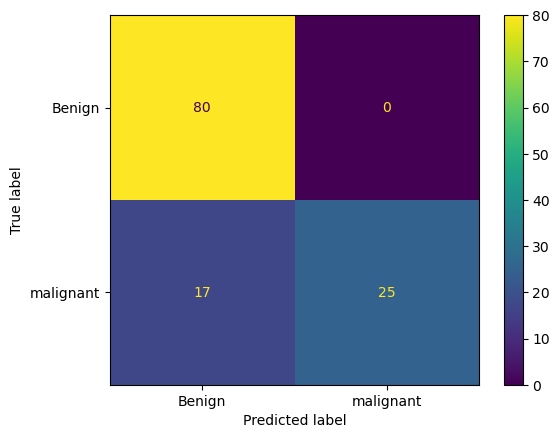

In [26]:
from sklearn import metrics
import matplotlib.pyplot as plt

df_prd = prd.select('label', 'prediction').toPandas()
cm = metrics.confusion_matrix(df_prd['label'], df_prd['prediction'])
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=['Benign','malignant'])
cm_display.plot()
plt.show()

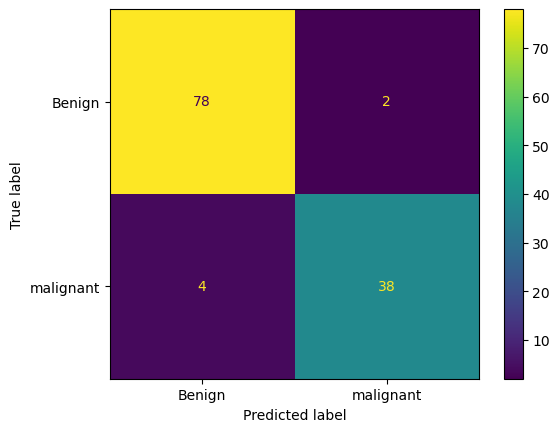

In [27]:
df_prd2 = prd2.select('label', 'prediction').toPandas()
cm = metrics.confusion_matrix(df_prd2['label'], df_prd2['prediction'])
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=['Benign','malignant'])
cm_display.plot()
plt.show()